In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
from langdetect import detect
import langid
from mtranslate import translate
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

### Importation des donnees

In [2]:
df_1_2 = pd.read_csv('df_1-2.csv')
df_3_5 = pd.read_csv('df_3-5.csv')
df_6_10 = pd.read_csv('df_6-10.csv')
df_11_13 = pd.read_csv('df_11-13.csv')
df_14_19 = pd.read_csv('df_14-19.csv')
df_20_23 = pd.read_csv('df_20-23.csv')
df_24_27 = pd.read_csv('df_24-27.csv')
df_28_31 = pd.read_csv('df_28-31.csv')

In [3]:
# concatenation des dataFrame
df1 = pd.concat([df_1_2, df_3_5, df_6_10, df_11_13, df_14_19, df_20_23, df_24_27, df_28_31])

### exploration data

In [4]:
df1.shape

(31000, 84)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31000 entries, 0 to 3999
Data columns (total 84 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           31000 non-null  int64  
 1   node_id                      31000 non-null  object 
 2   name                         31000 non-null  object 
 3   full_name                    31000 non-null  object 
 4   private                      31000 non-null  bool   
 5   owner                        31000 non-null  object 
 6   html_url                     31000 non-null  object 
 7   description                  22099 non-null  object 
 8   fork                         31000 non-null  bool   
 9   url                          31000 non-null  object 
 10  forks_url                    31000 non-null  object 
 11  keys_url                     31000 non-null  object 
 12  collaborators_url            31000 non-null  object 
 13  teams_url        

In [6]:
columns_to_save = ['id', 'node_id','full_name', 'description', 'created_at', 'updated_at', 
                   'pushed_at', 'size', 'languages', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 
                   'has_pages', 'has_discussions', 'archived', 'disabled', 'is_template', 'web_commit_signoff_required', 
                   'forks', 'open_issues','stargazers_count', 'default_branch', 'subscribers_count']

df = df1[columns_to_save]

In [7]:
df.describe()

,id,size,forks,open_issues,stargazers_count,subscribers_count
count,3.100000e+04,3.100000e+04,31000.000000,31000.000000,31000.000000,31000.000000
mean,5.899201e+08,2.395094e+04,4.534548,1.513516,24.197903,1.122516
std,3.696715e+06,2.592355e+05,53.433470,10.731782,245.730260,2.344205
min,5.840196e+08,0.000000e+00,0.000000,0.000000,2.000000,0.000000
25%,5.865995e+08,6.300000e+01,0.000000,0.000000,4.000000,0.000000
50%,5.895807e+08,5.120000e+02,0.000000,0.000000,6.000000,1.000000
75%,5.942946e+08,4.876250e+03,2.000000,1.000000,11.000000,1.000000
max,5.958532e+08,2.116619e+07,6784.000000,1044.000000,21790.000000,30.000000


### nettoyage data 

In [8]:
# les duplicates
duplicates_count = df.duplicated().sum()
duplicates_count

4135

In [9]:
# supprimer les duplicates
df = df.drop_duplicates()
df.shape

(26865, 24)

In [10]:
# les valeur Na
nan_count = df.isna().sum().sum()
nan_count

7642

In [11]:
# remplacer les Na par "without description"
df['description'] = df['description'].fillna('without description')

In [12]:
# vérifier la colonne id
values_negatife = df[df['id'] < 0]
values_negatife

,id,node_id,full_name,description,created_at,updated_at,pushed_at,size,languages,has_issues,...,has_discussions,archived,disabled,is_template,web_commit_signoff_required,forks,open_issues,stargazers_count,default_branch,subscribers_count


In [13]:
# corrections des type des colonnes 
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['pushed_at'] = pd.to_datetime(df['pushed_at'])
df['web_commit_signoff_required'] = df['web_commit_signoff_required'].astype(bool)

## Traitement des Langues

In [14]:
# transformer la colonne en dictionnaire
df['languages'] = df['languages'].apply(lambda x: ast.literal_eval(x))

# separation la colonne en valeurs et keys
df['language_keys'] = df['languages'].apply(lambda x: list(x.keys()))
df['language_values'] = df['languages'].apply(lambda x: list(x.values()))

In [15]:
# supprimer les valeur Na
empty_lists = (df['language_keys'].apply(len) == 0) & (df['language_values'].apply(len) == 0)

df = df[~empty_lists].reset_index(drop=True)
df

,id,node_id,full_name,description,created_at,updated_at,pushed_at,size,languages,has_issues,...,disabled,is_template,web_commit_signoff_required,forks,open_issues,stargazers_count,default_branch,subscribers_count,language_keys,language_values
0,584280578,R_kgDOItNqAg,data-storage-lab/ConfD,Analyzing Configuration Dependencies of File S...,2023-01-02 05:05:41+00:00,2023-03-03 18:39:13+00:00,2023-03-03 18:43:53+00:00,131,"{'Roff': 0.4032792497585191, 'Python': 0.34478...",True,...,False,False,False,0,0,8,main,1,"[Roff, Python, C++, Shell, CMake]","[0.4032792497585191, 0.3447899217887113, 0.216..."
1,584528479,R_kgDOItcyXw,exyte/android-waves-progressbar,"A depth gauge progress bar, inspired by Apple ...",2023-01-02 20:35:10+00:00,2023-06-22 15:21:57+00:00,2023-06-03 10:13:56+00:00,120,{'Kotlin': 1.0},True,...,False,False,False,1,0,8,master,4,[Kotlin],[1.0]
2,584494922,R_kgDOItavSg,Sid-WC121/StopWatch-ReactJS,without description,2023-01-02 18:19:19+00:00,2023-02-13 17:19:36+00:00,2023-01-03 16:25:31+00:00,18,"{'JavaScript': 0.5668016194331984, 'CSS': 0.37...",True,...,False,False,False,0,0,8,main,1,"[JavaScript, CSS, HTML]","[0.5668016194331984, 0.37972916375820187, 0.05..."
3,584299779,R_kgDOItO1Aw,chichuDlong/CppPracticeForOpenFOAM,OpenFOAM框架下Cpp的基本应用,2023-01-02 06:45:33+00:00,2023-03-23 02:55:14+00:00,2023-03-23 01:26:16+00:00,3901,"{'C++': 0.9890864817137718, 'C': 0.01077777005...",True,...,False,False,False,5,0,8,master,1,"[C++, C, Shell]","[0.9890864817137718, 0.010777770058650972, 0.0..."
4,584498613,R_kgDOIta9tQ,nlztrk/OTTO-Multi-Objective-Recommender-System,without description,2023-01-02 18:33:05+00:00,2023-03-14 01:13:20+00:00,2023-01-31 19:52:25+00:00,124,{'Jupyter Notebook': 1.0},True,...,False,False,False,0,0,8,main,1,[Jupyter Notebook],[1.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,595575277,R_kgDOI3_B7Q,U7P4L-IN/FAKE-MAIL,😺FAKE MAIL SENDING COMMAND😸,2023-01-31 11:18:56+00:00,2023-06-16 18:01:25+00:00,2023-01-31 12:51:49+00:00,12,{'Python': 1.0},True,...,False,False,False,0,0,6,main,1,[Python],[1.0]
12100,595739226,R_kgDOI4JCWg,felippe-regazio/wcwc,Write Cool Web Components,2023-01-31 17:59:45+00:00,2023-02-19 19:28:53+00:00,2023-06-15 03:33:44+00:00,470,"{'TypeScript': 0.5158642462509866, 'JavaScript...",True,...,False,False,False,0,0,6,main,1,"[TypeScript, JavaScript, HTML]","[0.5158642462509866, 0.46650881347013945, 0.01..."
12101,595468878,R_kgDOI34iTg,abderox/X-game-socket,"Through this project, I am aiming to learn mor...",2023-01-31 06:16:00+00:00,2023-05-27 18:18:46+00:00,2023-02-03 00:47:29+00:00,3171,"{'TypeScript': 0.8648237476808905, 'CSS': 0.05...",True,...,False,False,False,0,0,6,master,1,"[TypeScript, CSS, HTML, JavaScript]","[0.8648237476808905, 0.05929499072356215, 0.03..."
12102,595853234,R_kgDOI4P_sg,accrescent/bundletool-gradle-plugin,A Gradle plugin for Google's bundletool,2023-01-31 23:59:40+00:00,2023-03-24 16:16:47+00:00,2023-06-07 21:39:25+00:00,184,{'Kotlin': 1.0},True,...,False,False,False,0,2,6,main,2,[Kotlin],[1.0]


## correction des formats et supprime la colonne original

In [16]:
# les valeurs en %
df['language_values'] = df['language_values'].apply(lambda x: [f'{value*100:.2f}%' for value in x])

In [17]:
# supprimer la colonne original
df = df.drop('languages', axis=1)

In [18]:
# renommer les colonnes
df = df.rename(columns={'subscribers_count': 'watchers'})
df = df.rename(columns={'stargazers_count': 'star'})
df = df.rename(columns={'language_values': 'language_percent'})
df = df.rename(columns={'language_keys': 'language_name'})

In [19]:
df.shape

(12104, 25)

## vérifier le valeurs null et vide

In [20]:
df.isna().sum()

id                             0
node_id                        0
full_name                      0
description                    0
created_at                     0
updated_at                     0
pushed_at                      0
size                           0
has_issues                     0
has_projects                   0
has_downloads                  0
has_wiki                       0
has_pages                      0
has_discussions                0
archived                       0
disabled                       0
is_template                    0
web_commit_signoff_required    0
forks                          0
open_issues                    0
star                           0
default_branch                 0
watchers                       0
language_name                  0
language_percent               0
dtype: int64

In [21]:
# vérifier les valeurs null
empty_count = (df == '').sum().sum()
empty_count

0

In [22]:
df

,id,node_id,full_name,description,created_at,updated_at,pushed_at,size,has_issues,has_projects,...,disabled,is_template,web_commit_signoff_required,forks,open_issues,star,default_branch,watchers,language_name,language_percent
0,584280578,R_kgDOItNqAg,data-storage-lab/ConfD,Analyzing Configuration Dependencies of File S...,2023-01-02 05:05:41+00:00,2023-03-03 18:39:13+00:00,2023-03-03 18:43:53+00:00,131,True,True,...,False,False,False,0,0,8,main,1,"[Roff, Python, C++, Shell, CMake]","[40.33%, 34.48%, 21.68%, 2.87%, 0.64%]"
1,584528479,R_kgDOItcyXw,exyte/android-waves-progressbar,"A depth gauge progress bar, inspired by Apple ...",2023-01-02 20:35:10+00:00,2023-06-22 15:21:57+00:00,2023-06-03 10:13:56+00:00,120,True,True,...,False,False,False,1,0,8,master,4,[Kotlin],[100.00%]
2,584494922,R_kgDOItavSg,Sid-WC121/StopWatch-ReactJS,without description,2023-01-02 18:19:19+00:00,2023-02-13 17:19:36+00:00,2023-01-03 16:25:31+00:00,18,True,True,...,False,False,False,0,0,8,main,1,"[JavaScript, CSS, HTML]","[56.68%, 37.97%, 5.35%]"
3,584299779,R_kgDOItO1Aw,chichuDlong/CppPracticeForOpenFOAM,OpenFOAM框架下Cpp的基本应用,2023-01-02 06:45:33+00:00,2023-03-23 02:55:14+00:00,2023-03-23 01:26:16+00:00,3901,True,True,...,False,False,False,5,0,8,master,1,"[C++, C, Shell]","[98.91%, 1.08%, 0.01%]"
4,584498613,R_kgDOIta9tQ,nlztrk/OTTO-Multi-Objective-Recommender-System,without description,2023-01-02 18:33:05+00:00,2023-03-14 01:13:20+00:00,2023-01-31 19:52:25+00:00,124,True,True,...,False,False,False,0,0,8,main,1,[Jupyter Notebook],[100.00%]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,595575277,R_kgDOI3_B7Q,U7P4L-IN/FAKE-MAIL,😺FAKE MAIL SENDING COMMAND😸,2023-01-31 11:18:56+00:00,2023-06-16 18:01:25+00:00,2023-01-31 12:51:49+00:00,12,True,True,...,False,False,False,0,0,6,main,1,[Python],[100.00%]
12100,595739226,R_kgDOI4JCWg,felippe-regazio/wcwc,Write Cool Web Components,2023-01-31 17:59:45+00:00,2023-02-19 19:28:53+00:00,2023-06-15 03:33:44+00:00,470,True,True,...,False,False,False,0,0,6,main,1,"[TypeScript, JavaScript, HTML]","[51.59%, 46.65%, 1.76%]"
12101,595468878,R_kgDOI34iTg,abderox/X-game-socket,"Through this project, I am aiming to learn mor...",2023-01-31 06:16:00+00:00,2023-05-27 18:18:46+00:00,2023-02-03 00:47:29+00:00,3171,True,True,...,False,False,False,0,0,6,master,1,"[TypeScript, CSS, HTML, JavaScript]","[86.48%, 5.93%, 3.83%, 3.76%]"
12102,595853234,R_kgDOI4P_sg,accrescent/bundletool-gradle-plugin,A Gradle plugin for Google's bundletool,2023-01-31 23:59:40+00:00,2023-03-24 16:16:47+00:00,2023-06-07 21:39:25+00:00,184,True,False,...,False,False,False,0,2,6,main,2,[Kotlin],[100.00%]


## nettoyer et traduit la colonne description

In [23]:
# supprimer les symbols, emoji ...

pattern = r'[^\w\s\u4E00-\u9FFF]'
df['description'] = df['description'].apply(lambda x: re.sub(pattern, '', x))
df['description'] = df['description'].replace(r'\s+', ' ', regex=True)

In [24]:
# traduit la colonne
df['description'] = df['description'].apply(lambda x: translate(x, 'en') if langid.classify(x)[0] != 'en' else x)

In [25]:
df.description

0        Analyzing Configuration Dependencies of File S...
1        A depth gauge progress bar inspired by Apple W...
2                                      without description
3        The basic application of Cpp under the framewo...
4                                      without description
                               ...                        
12099                            FAKE MAIL SENDING COMMAND
12100                            Write Cool Web Components
12101    Through this project I am aiming to learn more...
12102               A Gradle plugin for Googles bundletool
12103                   Repo of map vizzes using rayshader
Name: description, Length: 12104, dtype: object

In [26]:
# vérifier ' '
df['description'] = df['description'].str.strip()

In [27]:
# mettre tout la description en lower case
df['description'] = df['description'].str.lower()

## Détection et Traitement des Valeurs Aberrantes

In [29]:
# numbre des outliers
numerical_columns = ['size', 'forks', 'open_issues', 'star', 'watchers']

outlier_counts = {}

for column in numerical_columns:
    z_scores = stats.zscore(df[column])
    threshold = 3
    outlier_indices = np.where(z_scores > threshold)[0]
    outlier_count = len(outlier_indices)
    
    outlier_counts[column] = outlier_count

print("Number of outliers in each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")


Number of outliers in each column:
size: 56
forks: 58
open_issues: 73
star: 35
watchers: 217


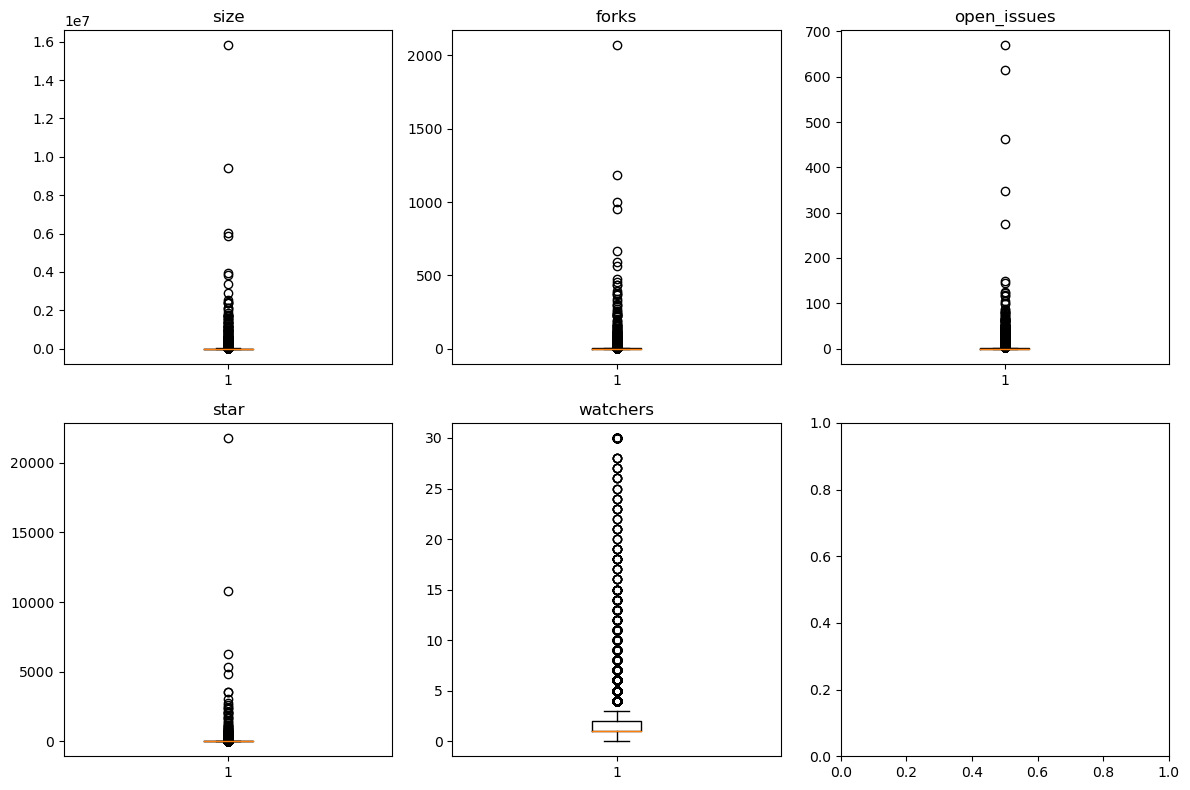

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, column in enumerate(numerical_columns):
    ax = axes[i // 3, i % 3]
    ax.boxplot(df[column])
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [31]:
lower_limit = 0.01
upper_limit = 0.99

# size
winsorized_size = np.clip(df['size'], df['size'].quantile(lower_limit), df['size'].quantile(upper_limit))
df['winsorized_size'] = winsorized_size

# forks
winsorized_forks = np.clip(df['forks'], df['forks'].quantile(lower_limit), df['forks'].quantile(upper_limit))
df['winsorized_forks'] = winsorized_forks

# open_issues
winsorized_open_issues = np.clip(df['open_issues'], df['open_issues'].quantile(lower_limit), df['open_issues'].quantile(upper_limit))
df['winsorized_open_issues'] = winsorized_open_issues

# star
winsorized_star = np.clip(df['star'], df['star'].quantile(lower_limit), df['star'].quantile(upper_limit))
df['winsorized_star'] = winsorized_star

# watchers
winsorized_watchers = np.clip(df['watchers'], df['watchers'].quantile(lower_limit), df['watchers'].quantile(upper_limit))
df['winsorized_watchers'] = winsorized_watchers


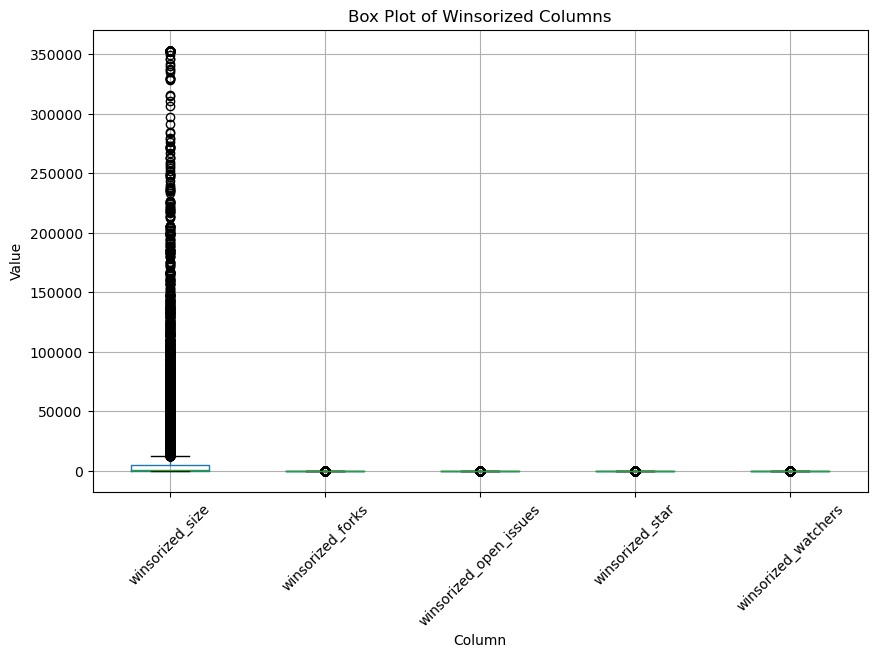

In [32]:
columns_to_plot = ['winsorized_size', 'winsorized_forks', 'winsorized_open_issues', 'winsorized_star', 'winsorized_watchers']

plt.figure(figsize=(10, 6))
df[columns_to_plot].boxplot()
plt.title('Box Plot of Winsorized Columns')
plt.xlabel('Column')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


## statistiques

In [35]:
normalized_columns = ['forks', 'open_issues',
                      'star', 'watchers']

for column in normalized_columns:
    min_value = df[column].min()
    max_value = df[column].max()
    mean_value = df[column].mean()
    std_value = df[column].std()
    
    print(f"Column: {column}")
    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")
    print(f"Mean value: {mean_value}")
    print(f"Standard deviation: {std_value}")
    print()


Column: forks
Min value: 0
Max value: 2068
Mean value: 4.140945142101785
Standard deviation: 31.806868789958934

Column: open_issues
Min value: 0
Max value: 669
Mean value: 1.723479841374752
Standard deviation: 11.794031931942389

Column: star
Min value: 3
Max value: 21790
Mean value: 25.33212161269002
Standard deviation: 259.7118753345543

Column: watchers
Min value: 0
Max value: 30
Mean value: 2.110872438863186
Standard deviation: 2.748561538369436



In [36]:
df

,id,node_id,full_name,description,created_at,updated_at,pushed_at,size,has_issues,has_projects,...,star,default_branch,watchers,language_name,language_percent,winsorized_size,winsorized_forks,winsorized_open_issues,winsorized_star,winsorized_watchers
0,584280578,R_kgDOItNqAg,data-storage-lab/ConfD,analyzing configuration dependencies of file s...,2023-01-02 05:05:41+00:00,2023-03-03 18:39:13+00:00,2023-03-03 18:43:53+00:00,131,True,True,...,8,main,1,"[Roff, Python, C++, Shell, CMake]","[40.33%, 34.48%, 21.68%, 2.87%, 0.64%]",131.0,0.0,0.0,8.0,1.0
1,584528479,R_kgDOItcyXw,exyte/android-waves-progressbar,a depth gauge progress bar inspired by apple w...,2023-01-02 20:35:10+00:00,2023-06-22 15:21:57+00:00,2023-06-03 10:13:56+00:00,120,True,True,...,8,master,4,[Kotlin],[100.00%],120.0,1.0,0.0,8.0,4.0
2,584494922,R_kgDOItavSg,Sid-WC121/StopWatch-ReactJS,without description,2023-01-02 18:19:19+00:00,2023-02-13 17:19:36+00:00,2023-01-03 16:25:31+00:00,18,True,True,...,8,main,1,"[JavaScript, CSS, HTML]","[56.68%, 37.97%, 5.35%]",18.0,0.0,0.0,8.0,1.0
3,584299779,R_kgDOItO1Aw,chichuDlong/CppPracticeForOpenFOAM,the basic application of cpp under the framewo...,2023-01-02 06:45:33+00:00,2023-03-23 02:55:14+00:00,2023-03-23 01:26:16+00:00,3901,True,True,...,8,master,1,"[C++, C, Shell]","[98.91%, 1.08%, 0.01%]",3901.0,5.0,0.0,8.0,1.0
4,584498613,R_kgDOIta9tQ,nlztrk/OTTO-Multi-Objective-Recommender-System,without description,2023-01-02 18:33:05+00:00,2023-03-14 01:13:20+00:00,2023-01-31 19:52:25+00:00,124,True,True,...,8,main,1,[Jupyter Notebook],[100.00%],124.0,0.0,0.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,595575277,R_kgDOI3_B7Q,U7P4L-IN/FAKE-MAIL,fake mail sending command,2023-01-31 11:18:56+00:00,2023-06-16 18:01:25+00:00,2023-01-31 12:51:49+00:00,12,True,True,...,6,main,1,[Python],[100.00%],12.0,0.0,0.0,6.0,1.0
12100,595739226,R_kgDOI4JCWg,felippe-regazio/wcwc,write cool web components,2023-01-31 17:59:45+00:00,2023-02-19 19:28:53+00:00,2023-06-15 03:33:44+00:00,470,True,True,...,6,main,1,"[TypeScript, JavaScript, HTML]","[51.59%, 46.65%, 1.76%]",470.0,0.0,0.0,6.0,1.0
12101,595468878,R_kgDOI34iTg,abderox/X-game-socket,through this project i am aiming to learn more...,2023-01-31 06:16:00+00:00,2023-05-27 18:18:46+00:00,2023-02-03 00:47:29+00:00,3171,True,True,...,6,master,1,"[TypeScript, CSS, HTML, JavaScript]","[86.48%, 5.93%, 3.83%, 3.76%]",3171.0,0.0,0.0,6.0,1.0
12102,595853234,R_kgDOI4P_sg,accrescent/bundletool-gradle-plugin,a gradle plugin for googles bundletool,2023-01-31 23:59:40+00:00,2023-03-24 16:16:47+00:00,2023-06-07 21:39:25+00:00,184,True,False,...,6,main,2,[Kotlin],[100.00%],184.0,0.0,2.0,6.0,2.0
